# Imports


In [32]:
import json
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
        
file_path = "C:/Users/wgabr/Jupyter Notebooks/TCC/CollectedDataJson/MeasuresDB.json"
analytics_file_redir = "C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/MeasuresDB_analytics_redir.json"
analytics_file_param = "C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/MeasuresDB_analytics_param.json"
resultsRedIr = "C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/resultsRedIr.json"
analytics_file_methods = "C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/resultsMethods.json"

## Helper Functions from the WEB App

In [33]:
########## NEUROKIT2 BASED FUNCTIONS ##########
def filter_signal(ppg_signal, sampling_rate):
    """Return an array with the filtered signal."""
    filtered_signal = nk.ppg_clean(ppg_signal, sampling_rate, heart_rate=None, method="elgendi")
    return filtered_signal

def peak_finder(ppg_cleaned, sampling_rate):
    """Return a dictionary with PPG info"""
    ppg_info = nk.ppg_findpeaks(ppg_cleaned, sampling_rate, method='elgendi', show=False)
    return ppg_info

def ppg_heart_beats(ppg_cleaned, peaks, sampling_rate, show=False):
    """
    Return a dict containing DataFrames for all segmented hearbeats.
    """
    ppg_epochs = nk.ppg_segment(ppg_cleaned, peaks, sampling_rate)
    return ppg_epochs

def ppg_sqa(ppg_cleaned, ppg_pw_peaks, sampling_rate):
    """
    Return a vector containing the quality index ranging from 0 to 1 for "templatematch" method,
    or an unbounded value (where 0 indicates high quality) for "disimilarity" method.
    """
    quality = nk.ppg_quality(ppg_cleaned, ppg_pw_peaks, sampling_rate, method='templatematch', approach=None)
    return quality

def ppg_process(ppg, sampling_rate):
    """
    Return for signals: dataframe with PPG_Raw, PPG_Clean, PPG_Rate, PPG_Peaks
    Return for info: dictionary containing the information of peaks and the signals sampling rate 
    """
    signals, info = nk.ppg_process(ppg, sampling_rate)
    return signals, info

def calculate_avg_beat(ir_beats):
    """
    Calculate the average beat from a dictionary of beats.

    Args:
        ir_beats (dict): Dictionary containing individual beats, where keys are beat indices 
                         and values are DataFrames with columns: 'Signal', 'Index', and 'Label'.

    Returns:
        pd.DataFrame: A DataFrame with the average signal and the corresponding time.
    """
    # Extract time indices and signals from each beat
    signals = []
    time_index = None

    for beat_df in ir_beats.values():
        if time_index is None:
            time_index = beat_df.index  # Use the index of the first beat as the reference
        
        # Ensure the signal is valid (handle NaN if present)
        signal = beat_df["Signal"].values
        if np.isnan(signal).any():
            #print("Warning: NaN values found in beat. Replacing NaN with zeros.")
            signal = np.nan_to_num(signal)
        
        signals.append(signal)

    # Stack all signals and compute the mean along the columns (time axis)
    signals_stack = np.vstack(signals)
    average_signal = np.nanmean(signals_stack, axis=0)  # Use nanmean to ignore NaN values

    # Create a DataFrame with the average signal and time
    average_signal_df = pd.DataFrame({
        "Time": time_index,  # Time is the index from the original DataFrame
        "Average Signal": average_signal
    })

    return average_signal_df

########## CUSTOM FUNCTIONS ##########
def fourier_bandpass_filter(signal, fs, low_cutoff=0.1, high_cutoff=10):
    """Apply Fourier-based bandpass filter to the signal while preserving baseline."""
    # Compute the frequency bins
    freqs = np.fft.fftfreq(len(signal), d=1/fs)
    
    # Perform FFT
    fft_signal = np.fft.fft(signal)
    
    # Save the DC component
    dc_component = fft_signal[0]
    
    # Zero out frequencies outside the bandpass range
    fft_signal[(np.abs(freqs) < low_cutoff) | (np.abs(freqs) > high_cutoff)] = 0
    
    # Restore the DC component if low_cutoff > 0
    if low_cutoff > 0:
        fft_signal[0] = dc_component
    
    # Inverse FFT to get the filtered signal
    return np.fft.ifft(fft_signal).real

def normalize_signal(signal, range_min=0, range_max=1):
    """Normalize the input data to a specified range."""
    signal = np.array(signal)  # Ensure input is a numpy array for easier manipulation
    signal_min = np.min(signal)
    signal_max = np.max(signal)

    # Avoid division by zero if all values in data are the same
    if signal_max == signal_min:
        return np.full_like(signal, range_min)  # Fill with the minimum of the range

    # Normalize to [0, 1] and then scale to the desired range
    normalized_data = (signal - signal_min) / (signal_max - signal_min)
    normalized_data = normalized_data * (range_max - range_min) + range_min

    return normalized_data



# Red + Ir Comparison

## Creating a new file to include the analytics

In [79]:
# Load JSON file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Extract and process relevant measurements
def extract_red_ir_data(data, key="1000 Hz - 8 samples"):
    filtered_data = []
    
    if key in data:
        for measure_id, measure in data[key].items():
            if measure.get("category") == "RED IR Comparison":
                ir_signal = np.array([int(x) for x in measure["IrSignal"].split(',')])
                red_signal = np.array([int(x) for x in measure["RedSignal"].split(',')])
                
                filtered_data.append({
                    "measure_id": measure_id,
                    "timestamp": measure["timestamp"],
                    "measure_time": measure["measureTime"],
                    "measure_frequency": measure["measureFrequency"],
                    "ir_signal": ir_signal,
                    "red_signal": red_signal
                })
    
    return pd.DataFrame(filtered_data)

data = load_json(file_path)
df = extract_red_ir_data(data)

df.to_json(analytics_file_redir, orient="records", indent=4)  # Save the new file

df.head()

,measure_id,timestamp,measure_time,measure_frequency,ir_signal,red_signal
0,measure_1,21/02/2025 22:41:22,6.048,124.007937,"[-534, -559, -553, -567, -627, -611, -647, -66...","[-865, -877, -885, -858, -891, -905, -940, -91..."
1,measure_2,21/02/2025 22:41:50,6.049,123.987436,"[-484, -506, -520, -508, -528, -515, -531, -50...","[-809, -799, -805, -764, -776, -765, -821, -76..."
2,measure_3,21/02/2025 22:42:02,6.050,123.966942,"[-744, -742, -800, -854, -801, -837, -873, -85...","[-816, -835, -787, -777, -807, -861, -780, -85..."
3,measure_4,21/02/2025 22:42:24,6.049,123.987436,"[-875, -886, -899, -892, -871, -836, -825, -81...","[-465, -500, -473, -451, -436, -464, -395, -36..."
4,measure_5,21/02/2025 22:42:45,6.049,123.987436,"[-236, -297, -270, -259, -302, -295, -304, -33...","[-225, -177, -204, -197, -184, -228, -204, -23..."


## Adding Signal Quality

In [80]:
def process_signals(df):
    def process_row(row):
        sampling_rate = row["measure_frequency"]  # Use measure-specific sampling rate
        
        # Convert signals to NumPy arrays for processing
        ir_signal = np.array(row["ir_signal"])
        red_signal = np.array(row["red_signal"])
        
        # Process IR signal
        ir_cleaned = filter_signal(ir_signal, sampling_rate)  # Ensure input is an array
        ir_peaks_dict = peak_finder(ir_cleaned, sampling_rate)
        ir_quality = ppg_sqa(ir_cleaned, ir_peaks_dict["PPG_Peaks"], sampling_rate)
        
        # Process Red signal
        red_cleaned = filter_signal(red_signal, sampling_rate)  # Ensure input is an array
        red_peaks_dict = peak_finder(red_cleaned, sampling_rate)
        red_quality = ppg_sqa(red_cleaned, red_peaks_dict["PPG_Peaks"], sampling_rate)
        
        return pd.Series({
            "ir_filtered": ir_cleaned.tolist(),  # Convert back to list for storage
            "ir_quality": ir_quality.tolist() if isinstance(ir_quality, np.ndarray) else ir_quality,
            "red_filtered": red_cleaned.tolist(),
            "red_quality": red_quality.tolist() if isinstance(red_quality, np.ndarray) else red_quality
        })
    
    # Apply function to each row and update the DataFrame in place
    df_processed = df.assign(**df.apply(process_row, axis=1).apply(pd.Series))
    
    return df_processed

# Process signals using the measure-specific sampling rate
df_quality = process_signals(df)

## Analysis

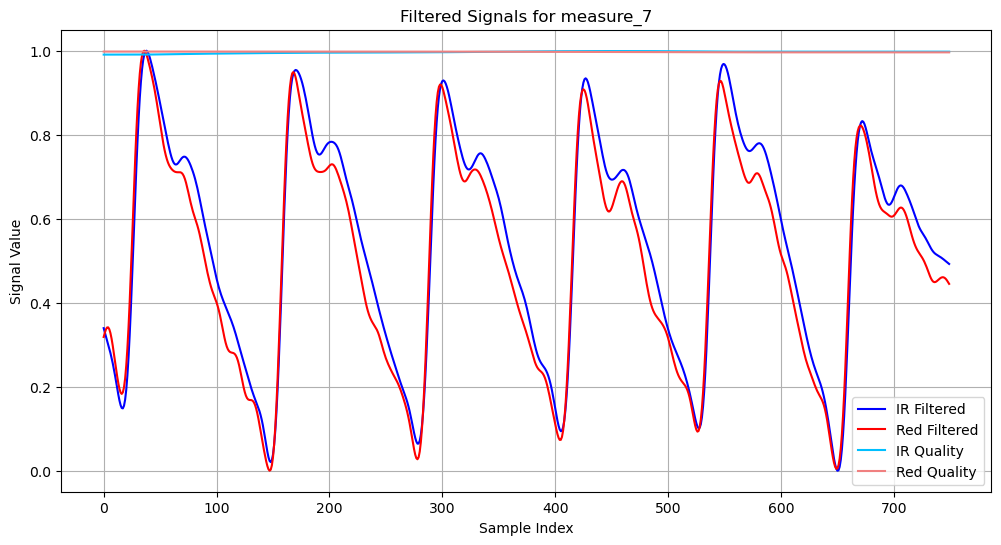

In [81]:
def plot_filtered_signals(df, measure_id):
    # Find the row corresponding to the given measure_id
    row = df[df["measure_id"] == measure_id]
    
    if row.empty:
        print(f"Measure '{measure_id}' not found.")
        return
    
    # Extract data
    ir_filtered = normalize_signal(np.array(row.iloc[0]["ir_filtered"]))
    ir_quality = np.array(row.iloc[0]["ir_quality"])
    red_filtered = normalize_signal(np.array(row.iloc[0]["red_filtered"]))
    red_quality = np.array(row.iloc[0]["red_quality"])
    
    # Generate sample indices
    sample_indices = np.arange(len(ir_filtered))

    # Plot
    plt.figure(figsize=(12, 6))
    
    # Filtered Signals
    plt.plot(sample_indices, ir_filtered, label="IR Filtered", color="blue")
    plt.plot(sample_indices, red_filtered, label="Red Filtered", color="red")

    # Quality Signals (lighter tones)
    plt.plot(sample_indices, ir_quality, label="IR Quality", color="deepskyblue")
    plt.plot(sample_indices, red_quality, label="Red Quality", color="lightcoral")

    # Labels and Legend
    plt.xlabel("Sample Index")
    plt.ylabel("Signal Value")
    plt.title(f"Filtered Signals for {measure_id}")
    plt.legend()
    plt.grid()
    
    plt.show()

# Function Call
plot_filtered_signals(df_quality, "measure_7")

In [82]:
def compute_quality_metrics(df, quality_threshold=0.98):
    def process_row(row):
        # Convert quality lists to numpy arrays
        ir_quality = np.array(row["ir_quality"])
        red_quality = np.array(row["red_quality"])

        # Compute metrics
        ir_good_quality = np.sum(ir_quality > quality_threshold)
        ir_min_quality = np.min(ir_quality)
        ir_max_quality = np.max(ir_quality)
        ir_quality_variance = np.var(ir_quality)

        red_good_quality = np.sum(red_quality > quality_threshold)
        red_min_quality = np.min(red_quality)
        red_max_quality = np.max(red_quality)
        red_quality_variance = np.var(red_quality)

        return [
            ir_good_quality, ir_min_quality, ir_max_quality, ir_quality_variance,
            red_good_quality, red_min_quality, red_max_quality, red_quality_variance
        ]

    # Compute new values for all rows
    new_values = df.apply(process_row, axis=1).tolist()

    # Define column names
    columns = [
        "ir_good_quality", "ir_min_quality", "ir_max_quality", "ir_quality_variance",
        "red_good_quality", "red_min_quality", "red_max_quality", "red_quality_variance"
    ]

    # Overwrite existing columns instead of appending
    df.loc[:, columns] = new_values  

    return df

# Example call
df_quality = compute_quality_metrics(df_quality)

df_quality.to_json("C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/quality.json", orient="table", indent=4)  # Save the new file


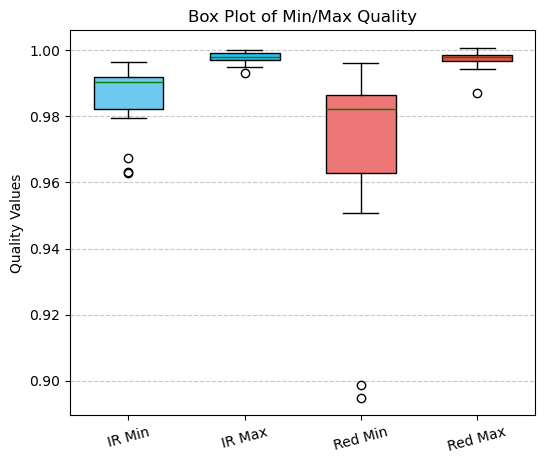

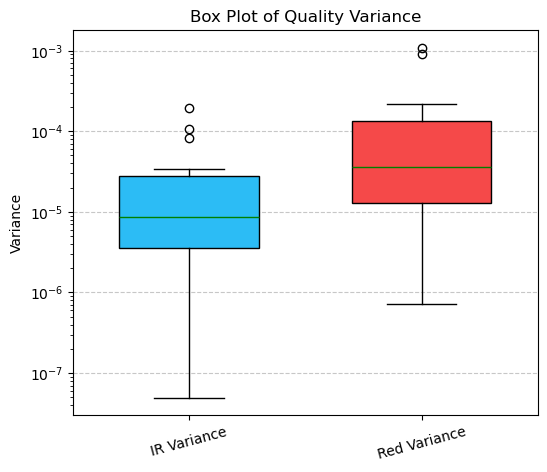

In [98]:
def separate_quality_boxplots(df):
    # First Figure: Min and Max Quality
    plt.figure(figsize=(6, 5))
    
    quality_labels = ["IR Min", "IR Max", "Red Min", "Red Max"]
    quality_data = [
        df["ir_min_quality"].dropna(),
        df["ir_max_quality"].dropna(),
        df["red_min_quality"].dropna(),
        df["red_max_quality"].dropna()
    ]

    box1 = plt.boxplot(quality_data, patch_artist=True, widths=0.6)
    plt.title("Box Plot of Min/Max Quality")
    plt.ylabel("Quality Values")
    plt.xticks(ticks=[1, 2, 3, 4], labels=quality_labels, rotation=15)
    
    # Set custom colors for median lines
    for median in box1["medians"]:
        median.set_color("green")
    # Set colors
    colors = ["#6dc9ed", "#2cbcf5", "#ed7777", "#f54949"]
    for patch, color in zip(box1["boxes"], colors):
        patch.set_facecolor(color)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Second Figure: Quality Variance
    plt.figure(figsize=(6, 5))

    variance_labels = ["IR Variance", "Red Variance"]
    variance_data = [
        df["ir_quality_variance"].dropna(),
        df["red_quality_variance"].dropna()
    ]

    box2 = plt.boxplot(variance_data, patch_artist=True, widths=0.6)
    plt.title("Box Plot of Quality Variance")
    plt.ylabel("Variance")
    plt.yscale("log")
    plt.xticks(ticks=[1, 2], labels=variance_labels, rotation=15)

    # Set custom colors for median lines
    for median in box2["medians"]:
        median.set_color("green")

    # Set colors
    variance_colors = ["#2cbcf5", "#f54949"]
    for patch, color in zip(box2["boxes"], variance_colors):
        patch.set_facecolor(color)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Call function
separate_quality_boxplots(df_quality)


# Parameters Comparison

## Creating a new file to include the analytics

In [84]:
# Load JSON file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Extract and process relevant measurements
def extract_param_data(data, key):
    filtered_data = []
    
    if key in data:
        for measure_id, measure in data[key].items():
            if measure.get("category") == "Parameters Comparison":
                ir_signal = np.array([int(x) for x in measure["IrSignal"].split(',')])
                
                filtered_data.append({
                    "measure_id": measure_id,
                    "parameters": key,
                    "timestamp": measure["timestamp"],
                    "measure_time": measure["measureTime"],
                    "measure_frequency": measure["measureFrequency"],
                    "ir_signal": ir_signal.tolist(),  # Ensure JSON serializable
                })
    
    return filtered_data

# Save analytics files for all parameter settings and return a DataFrame
def generate_analytics_df(input_file, output_file):
    # Load data
    data = load_json(input_file)
    
    # Accumulate all extracted data
    all_data = []
    
    for param_key in data.keys():
        all_data.extend(extract_param_data(data, param_key))  # Append data for each key

    # Convert to DataFrame
    df = pd.DataFrame(all_data)

    # Save to JSON
    if not df.empty:
        df.to_json(output_file, orient="records", indent=4)
        print(f"Saved: {output_file}")

    return df  # Return DataFrame for further analysis

# Example usage
df_param = generate_analytics_df(file_path, analytics_file_param)

df_param.head()  # Display the first few rows

Saved: C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/MeasuresDB_analytics_param.json


,measure_id,parameters,timestamp,measure_time,measure_frequency,ir_signal
0,measure_21,1000 Hz - 8 samples,22/02/2025 19:56:56,6.05,123.966942,"[-1619, -1545, -1534, -1508, -1388, -1410, -13..."
1,measure_22,1000 Hz - 8 samples,22/02/2025 19:57:13,6.05,123.966942,"[-1475, -1403, -1412, -1425, -1452, -1439, -14..."
2,measure_23,1000 Hz - 8 samples,22/02/2025 19:57:43,6.05,123.966942,"[-1888, -1878, -1885, -1920, -1892, -1907, -19..."
3,measure_24,1000 Hz - 8 samples,22/02/2025 19:57:55,6.05,123.966942,"[-1669, -1621, -1614, -1663, -1716, -1659, -16..."
4,measure_25,1000 Hz - 8 samples,22/02/2025 19:58:08,6.05,123.966942,"[-1274, -1299, -1307, -1373, -1395, -1399, -14..."


## Adding Signal Quality

In [85]:
def process_signals(df):
    def process_row(row):
        sampling_rate = row["measure_frequency"]  # Use measure-specific sampling rate
        
        # Convert signals to NumPy arrays for processing
        ir_signal = (np.array(row["ir_signal"]))
        
        # Process IR signal
        ir_cleaned = filter_signal(ir_signal, sampling_rate)  # Ensure input is an array
        ir_peaks_dict = peak_finder(ir_cleaned, sampling_rate)
        ir_quality = ppg_sqa(ir_cleaned, ir_peaks_dict["PPG_Peaks"], sampling_rate)
        ir_savgol = savgol_filter(ir_signal, window_length=7, polyorder=2)
               
        return pd.Series({
            "ir_filtered_savgol": ir_savgol.tolist(),
            "ir_filtered": ir_cleaned.tolist(),  # Convert back to list for storage
            "ir_quality": ir_quality.tolist() if isinstance(ir_quality, np.ndarray) else ir_quality
        })
    
    # Apply function to each row and update the DataFrame in place
    df_processed = df.assign(**df.apply(process_row, axis=1).apply(pd.Series))
    
    return df_processed

# Process signals using the measure-specific sampling rate
df_quality_param = process_signals(df_param)

df_quality_param.to_json("C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/quality_param.json", orient="table", indent=4)  # Save the new file

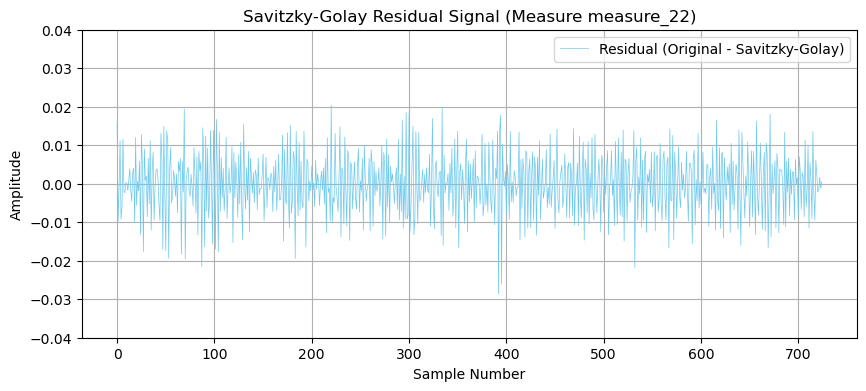

In [104]:
# Function to compute and plot the difference for a specific index
def plot_savgol_difference(df, index):
    if index >= len(df) or index < 0:
        print("Index out of range. Please select a valid index.")
        return
    
    row = df.iloc[index]  # Select row by index
    
    #original_signal = normalize_signal(np.array(row["ir_signal"]))
    #savgol_filtered = normalize_signal(np.array(row["ir_filtered_savgol"]))

    original_signal = normalize_signal(np.array(row["ir_signal"]))
    savgol_filtered = savgol_filter(original_signal, window_length=7, polyorder=2)

    # Exclude the first 25 samples
    original_trimmed = original_signal[25:]
    savgol_trimmed = savgol_filtered[25:]

    # Compute the difference (residual signal)
    residual_signal = original_trimmed - savgol_trimmed

    # Plot the results
    plt.figure(figsize=(10, 4))
    plt.plot(residual_signal, label="Residual (Original - Savitzky-Golay)", color="#6dc9ed", linewidth=0.5)
    plt.title(f"Savitzky-Golay Residual Signal (Measure {row['measure_id']})")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude")
    plt.ylim(-0.04, 0.04)
    plt.legend()
    plt.grid()
    plt.show()

# Example usage: Select measure by index (e.g., 0 for the first, 5 for the sixth)
plot_savgol_difference(df_quality_param, index=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


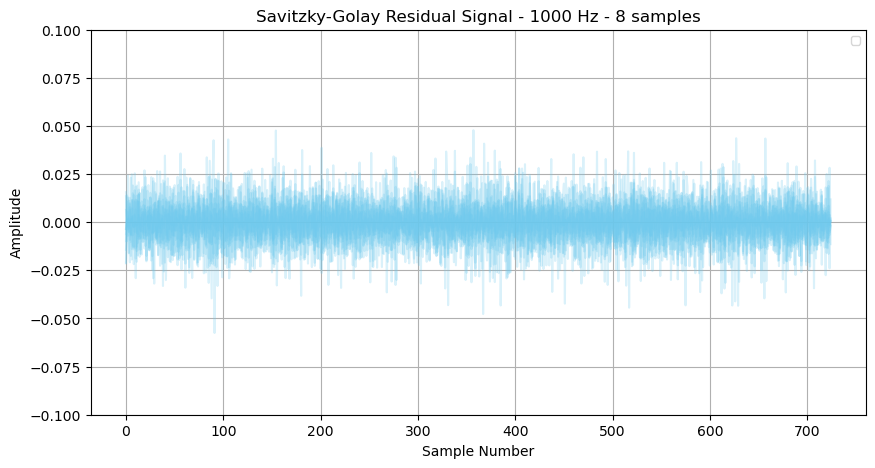

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


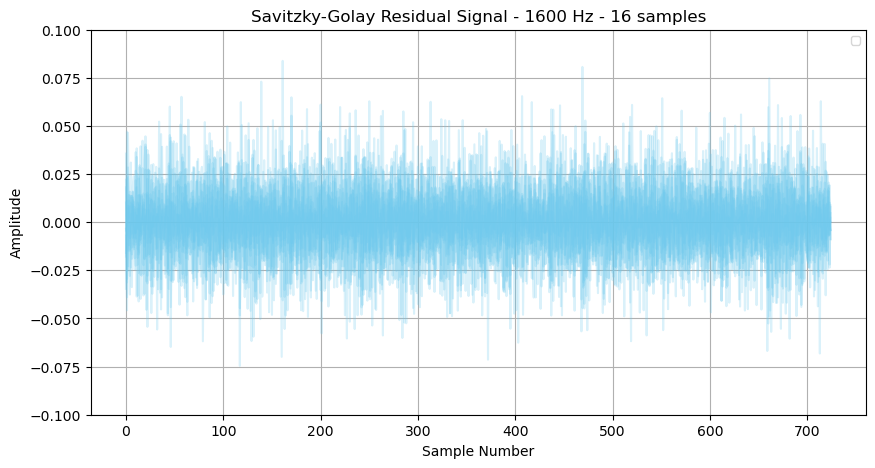

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


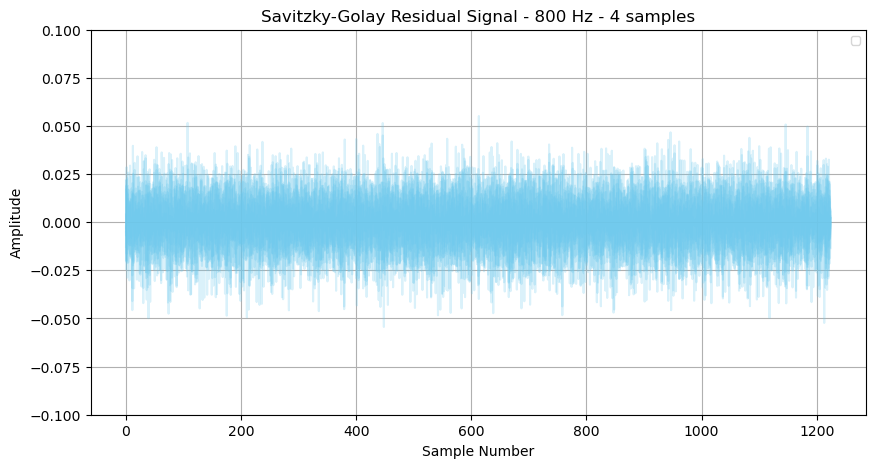

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


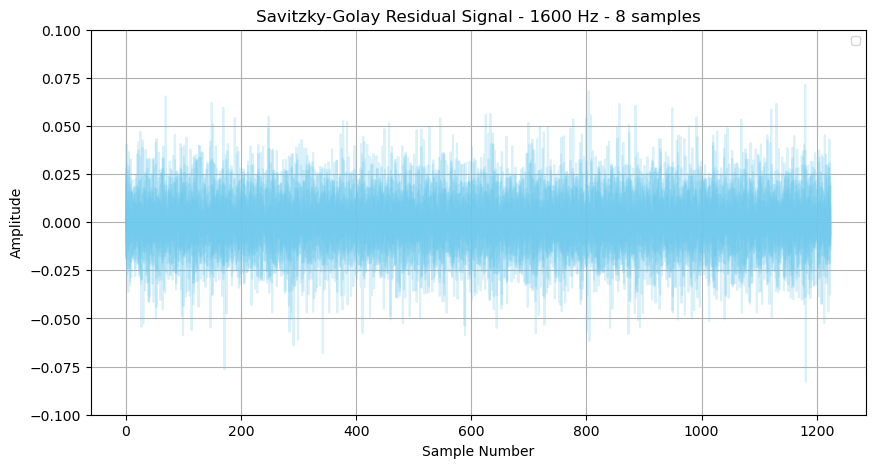

In [105]:
def plot_savgol_difference_by_parameters(df):
    # Get unique parameter settings
    unique_params = df["parameters"].unique()

    for param in unique_params:
        df_subset = df[df["parameters"] == param]
        
        plt.figure(figsize=(10, 5))
        
        for index, row in df_subset.iterrows():
            #original_signal = normalize_signal(np.array(row["ir_signal"]))
            #savgol_filtered = normalize_signal(np.array(row["ir_filtered_savgol"]))

            original_signal = normalize_signal(np.array(row["ir_signal"]))
            savgol_filtered = savgol_filter(original_signal, window_length=7, polyorder=2)

            # Exclude the first 25 samples
            residual_signal = original_signal[25:] - savgol_filtered[25:]

            # Plot each measure in the same figure
            plt.plot(residual_signal, alpha=0.25, color='#6dc9ed')

        plt.title(f"Savitzky-Golay Residual Signal - {param}")
        plt.xlabel("Sample Number")
        plt.ylabel("Amplitude")
        plt.ylim(-0.1, 0.1)
        plt.legend(loc="upper right", fontsize="small", ncol=2)
        plt.grid()
        plt.show()

# Call the function
plot_savgol_difference_by_parameters(df_quality_param)


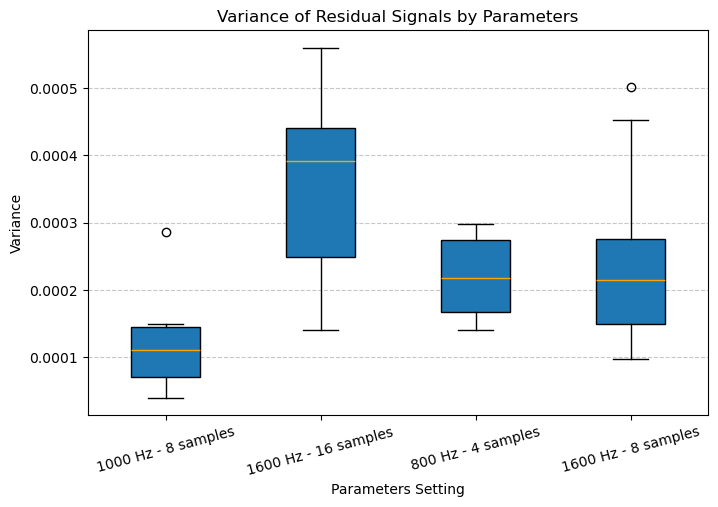

In [106]:
# Dictionary to store variances
variance_dict = {}

# Compute variance for each parameter
for param in df_quality_param["parameters"].unique():
    df_subset = df_quality_param[df_quality_param["parameters"] == param]
    
    variances = []
    
    for _, row in df_subset.iterrows():
        #original_signal = normalize_signal(np.array(row["ir_signal"]))
        #savgol_filtered = normalize_signal(np.array(row["ir_filtered_savgol"]))

        original_signal = normalize_signal(np.array(row["ir_signal"]))
        savgol_filtered = savgol_filter(original_signal, window_length=7, polyorder=2)

        # Exclude the first 25 samples
        residual_signal = original_signal[25:] - savgol_filtered[25:]

        # Compute variance and store
        variances.append(np.var(residual_signal))
    
    # Store in dictionary
    variance_dict[param] = variances

# Convert to DataFrame for easier plotting
df_variance = pd.DataFrame.from_dict(variance_dict, orient="index").T

# Plot boxplot
plt.figure(figsize=(8, 5))
box = plt.boxplot(df_variance.values, patch_artist=True, labels=df_variance.columns)

# Customize median line color
for median in box['medians']:
    median.set_color("orange")

# Customizations
plt.title("Variance of Residual Signals by Parameters")
plt.xlabel("Parameters Setting")
plt.ylabel("Variance")
plt.xticks(rotation=15)  # Rotate labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


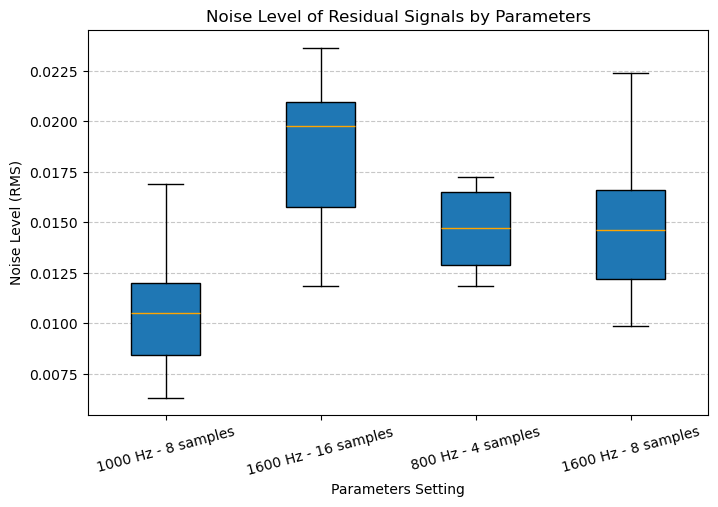

In [107]:
# Dictionary to store noise levels
noise_dict = {}

# Compute noise level for each parameter
for param in df_quality_param["parameters"].unique():
    df_subset = df_quality_param[df_quality_param["parameters"] == param]
    
    noise_levels = []
    
    for _, row in df_subset.iterrows():
        #original_signal = normalize_signal(np.array(row["ir_signal"]))
        #savgol_filtered = normalize_signal(np.array(row["ir_filtered_savgol"]))

        original_signal = normalize_signal(np.array(row["ir_signal"]))
        savgol_filtered = savgol_filter(original_signal, window_length=7, polyorder=2)

        # Exclude the first 25 samples
        residual_signal = original_signal[25:] - savgol_filtered[25:]

        # Compute noise level (RMS)
        noise_level = np.sqrt(np.mean(residual_signal**2))
        noise_levels.append(noise_level)
    
    # Store in dictionary
    noise_dict[param] = noise_levels

# Convert to DataFrame for easier plotting
df_noise = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in noise_dict.items()]))

# Plot boxplot
plt.figure(figsize=(8, 5))
box = plt.boxplot(df_noise.values, patch_artist=True, labels=df_noise.columns)

# Customize median line color
for median in box['medians']:
    median.set_color("orange")

# Customizations
plt.title("Noise Level of Residual Signals by Parameters")
plt.xlabel("Parameters Setting")
plt.ylabel("Noise Level (RMS)")
plt.xticks(rotation=15)  # Rotate labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Measure Procedure

## Creating new dataset

In [53]:
# Load JSON file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Extract and process relevant measurements
def extract_red_ir_data(data, key="1000 Hz - 8 samples"):
    filtered_data = []
    valid_categories = ("Rest and Clamped", "Rest Unclamped", "Unrest Clamped", "Clamped with motion")
    
    if key in data:
        for measure_id, measure in data[key].items():
            if measure.get("category") in valid_categories:
                ir_signal = np.array([int(x) for x in measure["IrSignal"].split(',')])
                
                filtered_data.append({
                    "category": measure.get("category"),
                    "measure_id": measure_id,
                    "timestamp": measure["timestamp"],
                    "measure_time": measure["measureTime"],
                    "measure_frequency": measure["measureFrequency"],
                    "ir_signal": ir_signal,
                })
    
    return pd.DataFrame(filtered_data)

data = load_json(file_path)
df = extract_red_ir_data(data)

df.to_json(analytics_file_methods, orient="records", indent=4)  # Save the new file

df.head()

,category,measure_id,timestamp,measure_time,measure_frequency,ir_signal
0,Rest and Clamped,measure_31,01/03/2025 15:50:00,8.066,123.977188,"[-3124, -3150, -3145, -3199, -3214, -3260, -32..."
1,Rest and Clamped,measure_32,01/03/2025 15:50:23,8.065,123.992560,"[-667, -552, -385, -301, -223, -123, -99, -59,..."
2,Rest and Clamped,measure_33,01/03/2025 15:50:38,8.066,123.977188,"[-1385, -1394, -1370, -1451, -1444, -1466, -15..."
3,Rest and Clamped,measure_34,01/03/2025 15:50:55,8.066,123.977188,"[-916, -918, -935, -947, -965, -1023, -1057, -..."
4,Rest and Clamped,measure_35,01/03/2025 15:55:46,8.066,123.977188,"[-1598, -1583, -1640, -1625, -1687, -1662, -16..."


## Adding Signal Quality and Savgol Filter

In [54]:
def compute_quality_metrics(df, quality_threshold=0.98):
    def process_row(row):
        # Convert quality lists to numpy arrays
        ir_quality = np.array(row["ir_quality"])

        # Compute metrics
        ir_good_quality = np.sum(ir_quality > quality_threshold)
        ir_min_quality = np.min(ir_quality)
        ir_max_quality = np.max(ir_quality)
        ir_quality_variance = np.var(ir_quality)

        return [ir_good_quality, ir_min_quality, ir_max_quality, ir_quality_variance]

    # Compute new values for all rows
    new_values = df.apply(process_row, axis=1).tolist()

    # Define column names
    columns = [
        "ir_good_quality", "ir_min_quality", "ir_max_quality", "ir_quality_variance"
    ]

    # Overwrite existing columns instead of appending
    df.loc[:, columns] = new_values  

    return df

def process_signals(df):
    def process_row(row):
        sampling_rate = row["measure_frequency"]  # Use measure-specific sampling rate
        
        # Convert signals to NumPy arrays for processing
        ir_signal = (np.array(row["ir_signal"]))
        
        # Process IR signal
        ir_cleaned = filter_signal(ir_signal, sampling_rate)  # Ensure input is an array
        ir_peaks_dict = peak_finder(ir_cleaned, sampling_rate)
        ir_quality = ppg_sqa(ir_cleaned, ir_peaks_dict["PPG_Peaks"], sampling_rate)
        ir_savgol = savgol_filter(ir_signal, window_length=7, polyorder=2)
               
        return pd.Series({
            "ir_filtered_savgol": ir_savgol.tolist(),
            "ir_filtered": ir_cleaned.tolist(),  # Convert back to list for storage
            "ir_quality": ir_quality.tolist() if isinstance(ir_quality, np.ndarray) else ir_quality
        })
    
    # Apply function to each row and update the DataFrame in place
    df_processed = df.assign(**df.apply(process_row, axis=1).apply(pd.Series))
    
    return df_processed

# Process signals using the measure-specific sampling rate
df_quality_methods = process_signals(df)
df_quality_methods = compute_quality_metrics(df_quality_methods)

df_quality_methods.to_json("C:/Users/wgabr/Jupyter Notebooks/TCC/Analytics/quality_methods.json", orient="table", indent=4)  # Save the new file

## Analysis

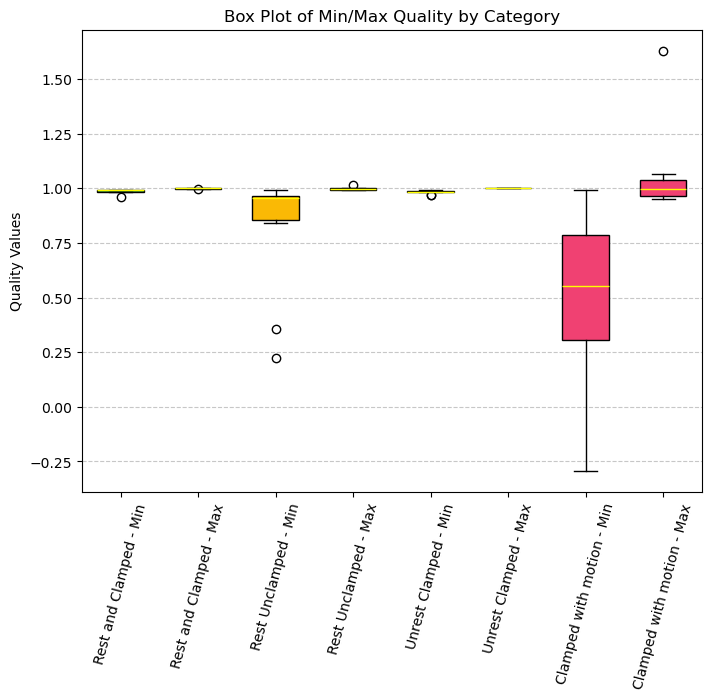

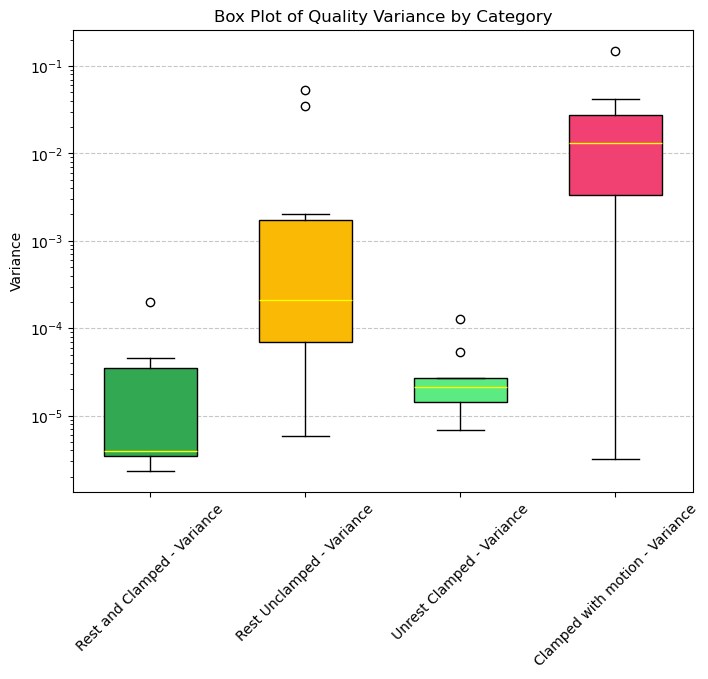

In [55]:
def separate_quality_boxplots(df):
    # Get unique categories
    unique_categories = df["category"].unique()
    
    # First Figure: Min and Max Quality (for all categories)
    plt.figure(figsize=(8, 6))

    quality_labels = []
    quality_data = []
    colors = ["#32a852", "#32a852", "#fab905", "#fab905", "#5beb82", "#5beb82", "#f04172", "#f04172"]
    colors_var = ["#32a852", "#fab905", "#5beb82", "#f04172"]

    for category in unique_categories:
        df_subset = df[df["category"] == category]
        quality_labels.extend([f"{category} - Min", f"{category} - Max"])
        quality_data.extend([
            df_subset["ir_min_quality"].dropna(),
            df_subset["ir_max_quality"].dropna()
        ])

    box1 = plt.boxplot(quality_data, patch_artist=True, widths=0.6)

    plt.title("Box Plot of Min/Max Quality by Category")
    plt.ylabel("Quality Values")
    plt.xticks(ticks=range(1, len(quality_labels) + 1), labels=quality_labels, rotation=75)

    # Set custom colors for median lines
    for median in box1["medians"]:
        median.set_color("yellow")

    # Set colors
    for patch, color in zip(box1["boxes"], colors * len(unique_categories)):  # Repeat colors
        patch.set_facecolor(color)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Second Figure: Quality Variance (for all categories)
    plt.figure(figsize=(8, 6))

    variance_labels = []
    variance_data = []

    for category in unique_categories:
        df_subset = df[df["category"] == category]
        variance_labels.append(f"{category} - Variance")
        variance_data.append(df_subset["ir_quality_variance"].dropna())

    box2 = plt.boxplot(variance_data, patch_artist=True, widths=0.6)
    
    plt.title("Box Plot of Quality Variance by Category")
    plt.ylabel("Variance")
    plt.yscale("log")  # Log scale for better visualization
    plt.xticks(ticks=range(1, len(variance_labels) + 1), labels=variance_labels, rotation=45)

    # Set custom colors for median lines
    for median in box2["medians"]:
        median.set_color("yellow")

    # Set colors
    for patch, color in zip(box2["boxes"], colors_var * len(unique_categories)):  # Repeat colors
        patch.set_facecolor(color)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Call function
separate_quality_boxplots(df_quality_methods)


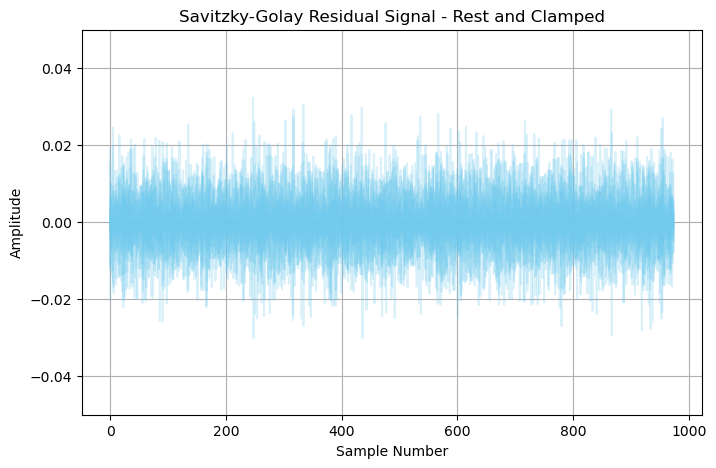

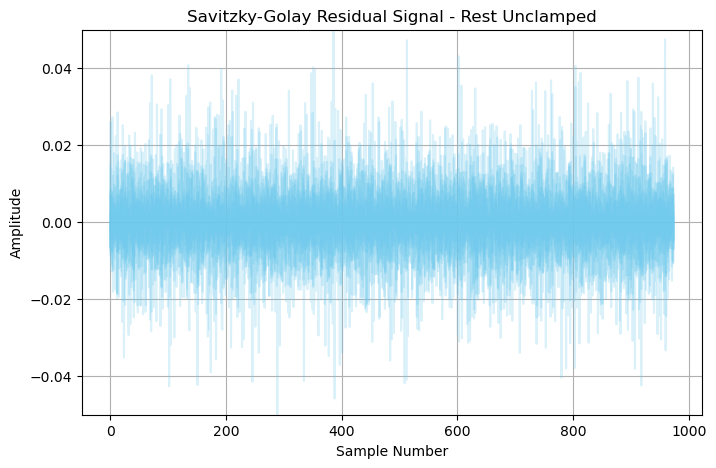

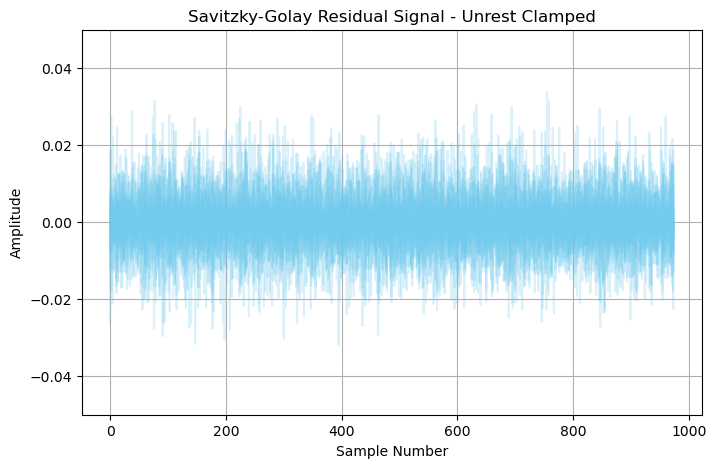

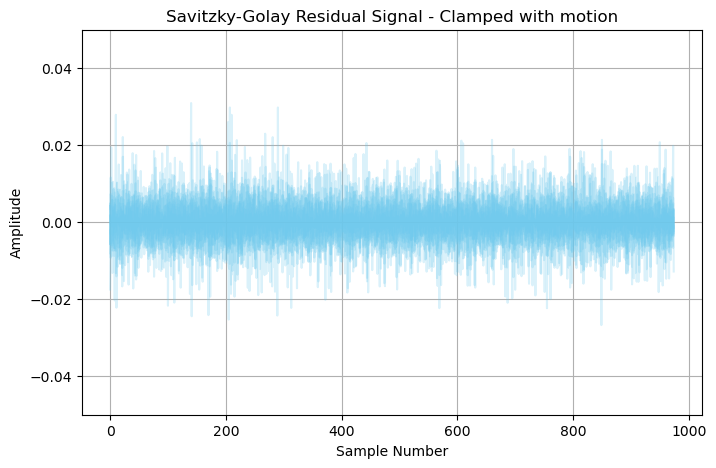

In [56]:
def plot_savgol_difference_by_category(df):
    # Get unique parameter settings
    unique_methods = df["category"].unique()

    for method in unique_methods:
        df_subset = df[df["category"] == method]
        
        plt.figure(figsize=(8, 5))
        
        for index, row in df_subset.iterrows():
            original_signal = normalize_signal(np.array(row["ir_signal"]))
            savgol_filtered = savgol_filter(original_signal, window_length=7, polyorder=2)

            # Exclude the first 25 samples
            residual_signal = original_signal[25:] - savgol_filtered[25:]

            # Plot each measure in the same figure
            plt.plot(residual_signal, alpha=0.25, color='#6dc9ed')

        plt.title(f"Savitzky-Golay Residual Signal - {method}")
        plt.xlabel("Sample Number")
        plt.ylabel("Amplitude")
        plt.ylim(-0.05, 0.05)
        plt.grid()
        plt.show()

# Call the function
plot_savgol_difference_by_category(df_quality_methods)


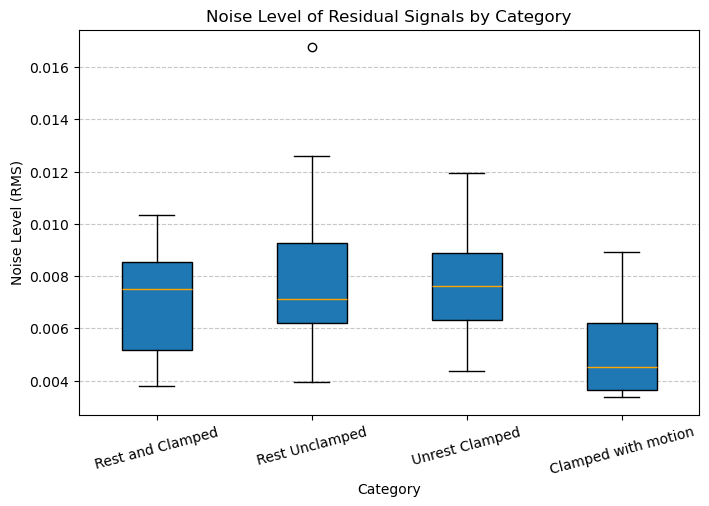

In [83]:
# Dictionary to store noise levels
noise_dict = {}

# Compute noise level for each parameter
for method in df_quality_methods["category"].unique():
    df_subset = df_quality_methods[df_quality_methods["category"] == method]
    
    noise_levels = []
    
    for _, row in df_subset.iterrows():
        original_signal = normalize_signal(np.array(row["ir_signal"]))
        savgol_filtered = savgol_filter(original_signal, window_length=7, polyorder=2)

        # Exclude the first 25 samples
        residual_signal = original_signal[25:] - savgol_filtered[25:]

        # Compute noise level (RMS)
        noise_level = np.sqrt(np.mean(residual_signal**2))
        noise_levels.append(noise_level)
    
    # Store in dictionary
    noise_dict[method] = noise_levels

# Convert to DataFrame for easier plotting
df_noise = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in noise_dict.items()]))

# Plot boxplot
plt.figure(figsize=(8, 5))
box = plt.boxplot(df_noise.values, patch_artist=True, labels=df_noise.columns)

# Customize median line color
for median in box['medians']:
    median.set_color("orange")

# Customizations
plt.title("Noise Level of Residual Signals by Category")
plt.xlabel("Category")
plt.ylabel("Noise Level (RMS)")
plt.xticks(rotation=15)  # Rotate labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

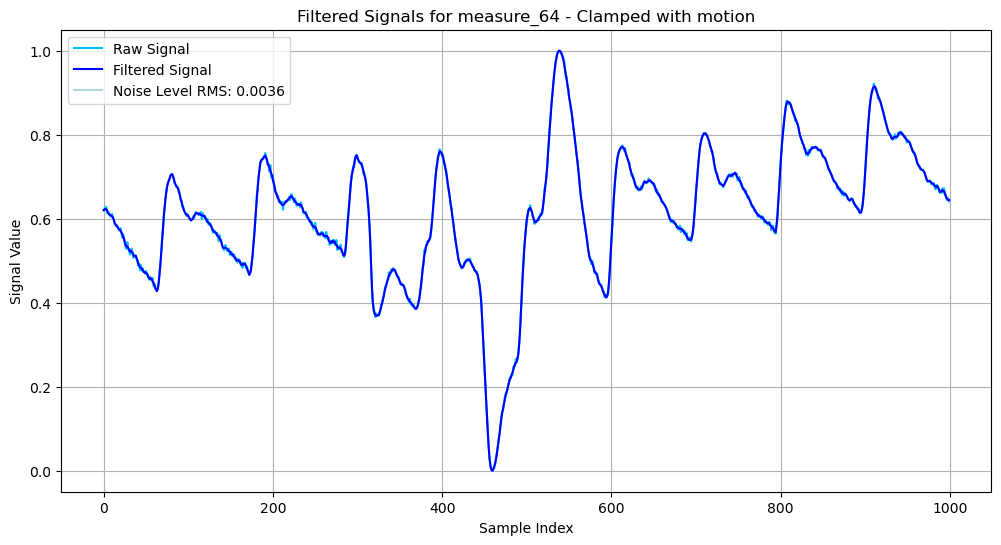

In [82]:
def plot_filtered_signals(df, measure_id):
    # Find the row corresponding to the given measure_id
    row = df[df["measure_id"] == measure_id]
    
    if row.empty:
        print(f"Measure '{measure_id}' not found.")
        return
    
    # Extract data
    ir_signal = normalize_signal(np.array(row.iloc[0]["ir_signal"]))
    ir_filtered = normalize_signal(np.array(row.iloc[0]["ir_filtered_savgol"]))

    # Exclude the first 25 samples
    residual_signal = ir_signal[25:] - ir_filtered[25:]

    # Compute noise level (RMS)
    noise_level = np.sqrt(np.mean(residual_signal**2))

    # Generate sample indices
    sample_indices = np.arange(len(ir_filtered))

    # Plot
    plt.figure(figsize=(12, 6))
    
    # Raw Signal
    plt.plot(sample_indices, ir_signal, label=f'Raw Signal', color="deepskyblue")

    # Filtered Signal
    plt.plot(sample_indices, ir_filtered, label="Filtered Signal", color="blue")

    # Noise Level Legend
    plt.plot([], [],label=f'Noise Level RMS: {noise_level:.4f}', color="lightblue")

    # Labels and Legend
    plt.xlabel("Sample Index")
    plt.ylabel("Signal Value")
    plt.title(f"Filtered Signals for {measure_id} - Clamped with motion")
    plt.legend()
    plt.grid()
    
    plt.show()

# Function Call
plot_filtered_signals(df_quality_methods, "measure_64")